In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#12E1

The smaller std one. 

12E2

center alpha around a hyperparameter alpha_bar, and std_bar and let them be distributed by a your prior knowledge. That way alpha group can vary and will have a posterior distribution that will be maximal when it does a good job for the majority of cases, which might be similar to the group mean intercept. 

12E3

same stuff

12E4




In [47]:
#12M1


d = pd.read_csv('Data/reedfrogs.csv', sep=",")


# make the tank cluster variable
tank = np.arange(d.shape[0])

d.head()

# predation dummy variable
d.loc[:,'pred'] = np.where(d.pred=='no',0,1)

# to simplify I will dummy code, 0,1
# careful d.size is overloaded here

d.loc[:,'size'] = np.where(d['size'] == 'small', 0,1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:05<00:00, 3000.13draws/s]


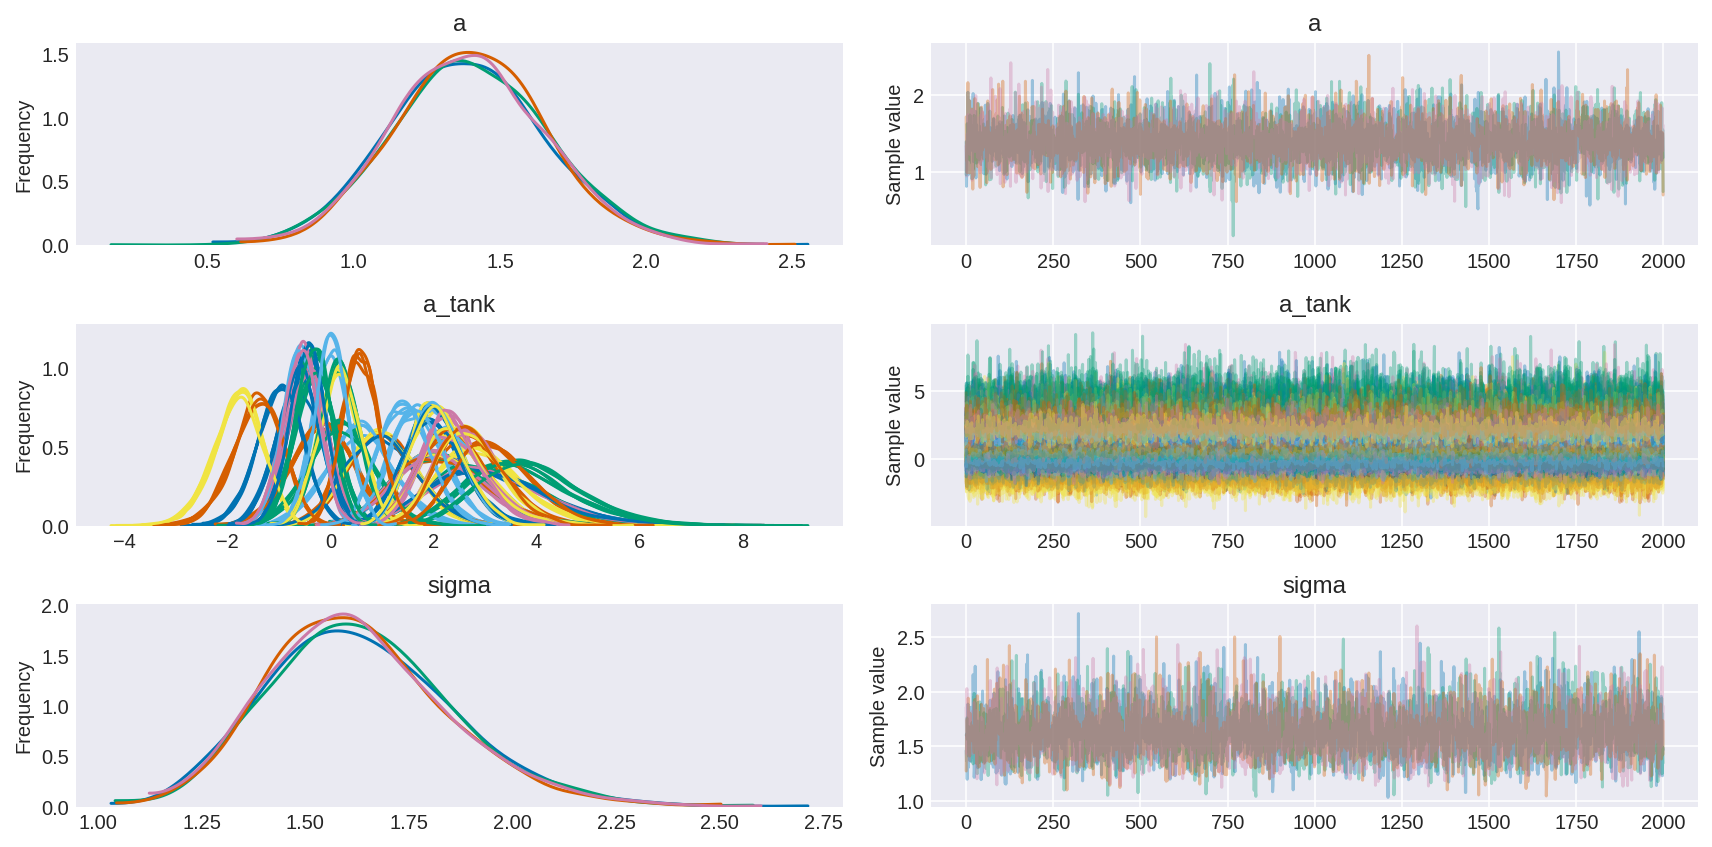

In [8]:
######## HIERARCHICAL ########
####### TADPOL SURVIVAL ######
# ========================== #

with pm.Model() as m_12_1:
    
    a = pm.Normal('a', 0., 10.) # hyper prior
    sigma = pm.HalfCauchy('sigma', 1.) # hyper prior
    
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0]) # prior
    
    p = pm.math.invlogit(a_tank[tank]) # modeling each bucket of tadpoles individuallly
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_12_1 = pm.sample(2000, tune=2000, njobs=4)
    
pm.traceplot(trace_12_1);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bp, a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:09<00:00, 1671.98draws/s]
The acceptance probability does not match the target. It is 0.6888673845875714, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


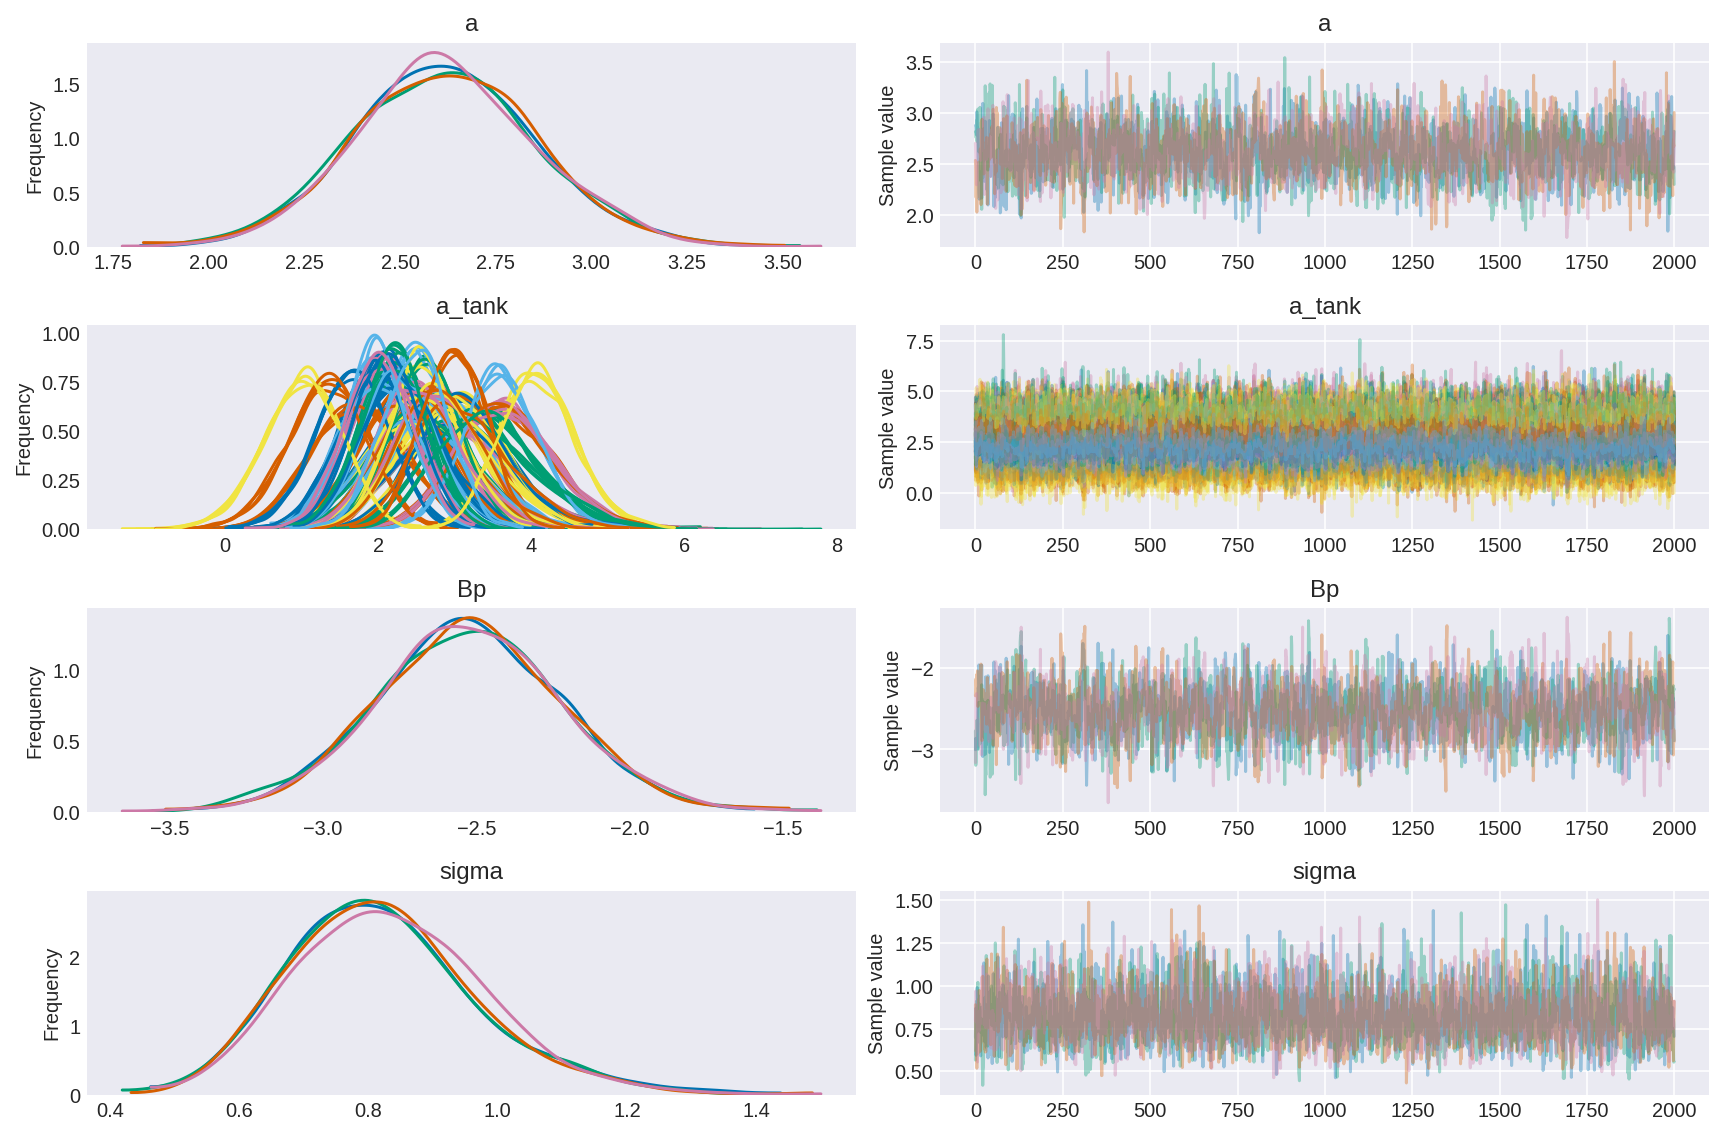

In [16]:
##############################
###### PREDATION #############
# with indicator variable ####

with pm.Model() as m_12_2:
    
    a = pm.Normal('a', 0., 10.) # hyper prior
    sigma = pm.HalfCauchy('sigma', 1.) # hyper prior
    
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0]) # prior
    Bp = pm.Normal('Bp', -1, 1) # expect predation to decrease probability of survival
    
    p = pm.math.invlogit(a_tank[tank] + Bp * d.pred) # modeling each bucket of tadpoles individuallly
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_12_2 = pm.sample(2000, tune=2000, njobs=4)
    
pm.traceplot(trace_12_2);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bs, a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:13<00:00, 1227.19draws/s]
The number of effective samples is smaller than 25% for some parameters.


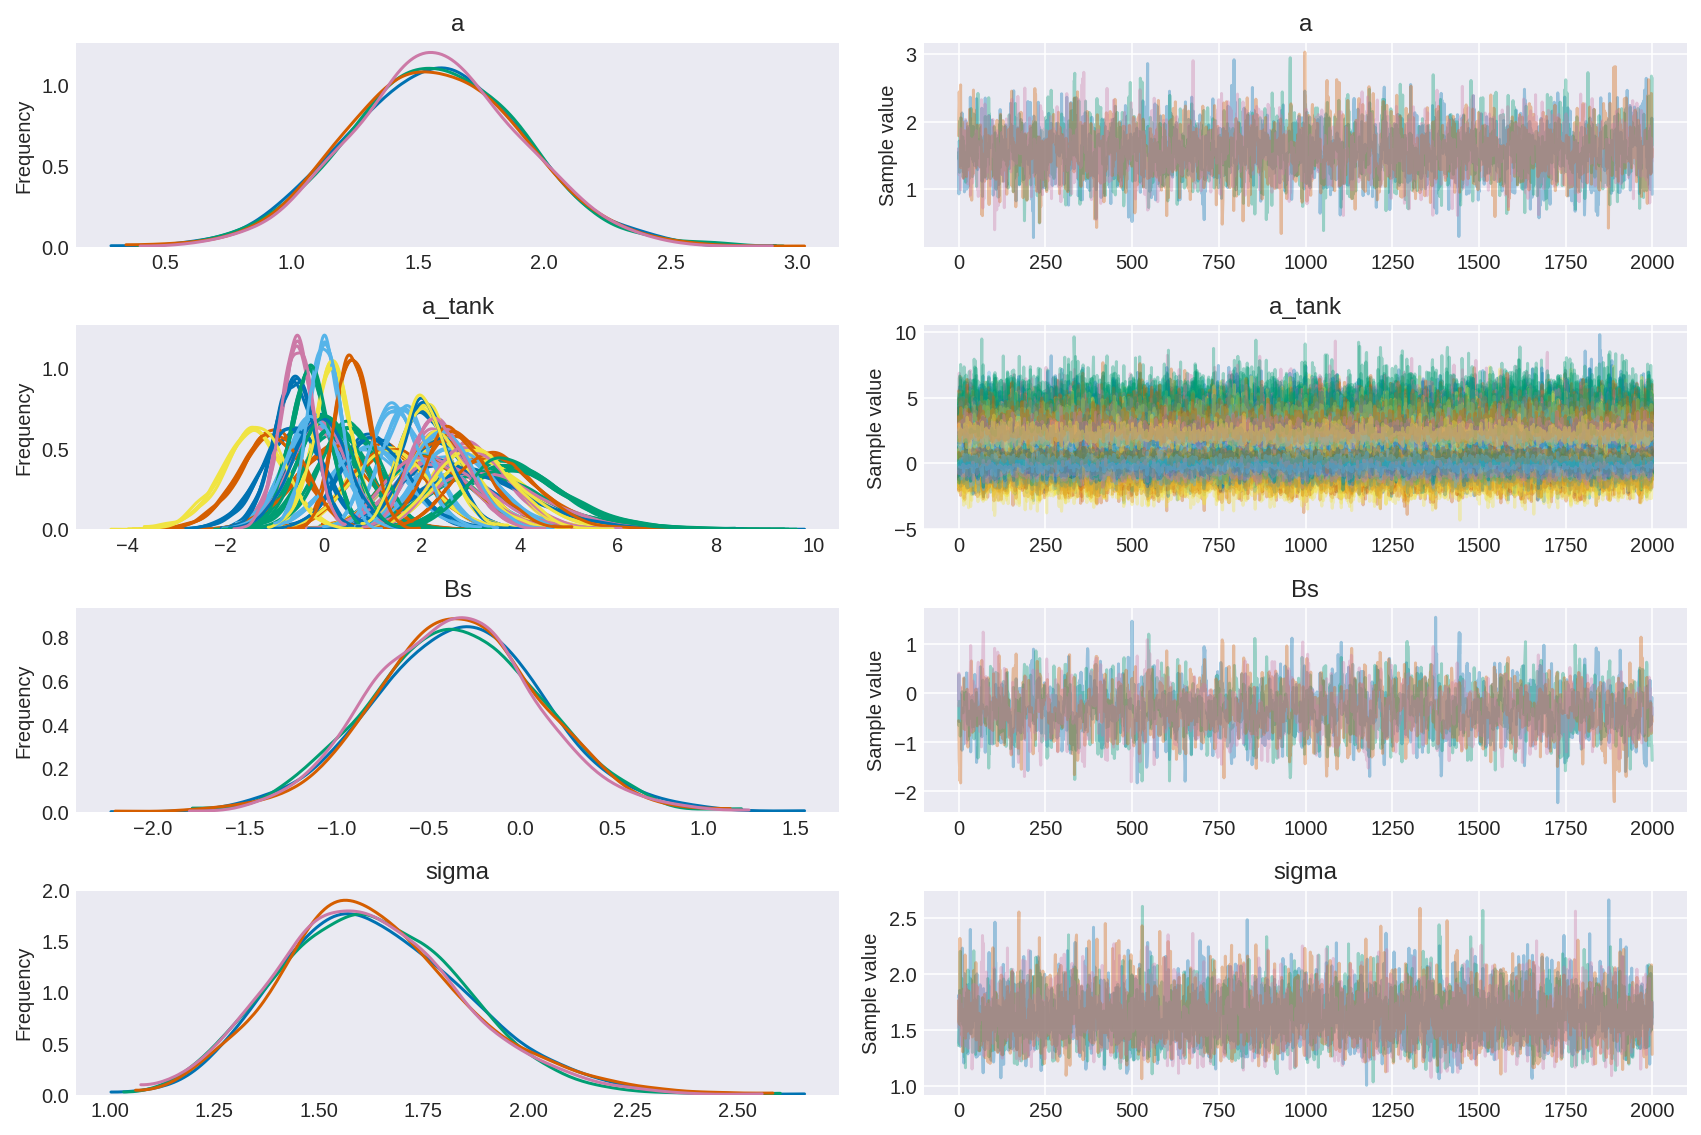

In [29]:
###########################
######   SIZE   ##########

with pm.Model() as m_12_3:
    
    a = pm.Normal('a', 0., 10.) # hyper prior
    sigma = pm.HalfCauchy('sigma', 1.) # hyper prior
    
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0]) # prior
    #Bp = pm.Normal('Bp', -1, 1) # expect predation to decrease probability of survival
    Bs = pm.Normal('Bs', 0,1) # no strong reason to think size will influence prob... right?
    
    
    p = pm.math.invlogit(a_tank[tank] + Bs * d['size'])#Bp * d.pred) 
    # modeling each bucket of tadpoles individuallly
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_12_3 = pm.sample(2000, tune=2000, njobs=4)
    
pm.traceplot(trace_12_3);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bs, Bp, a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:12<00:00, 1318.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


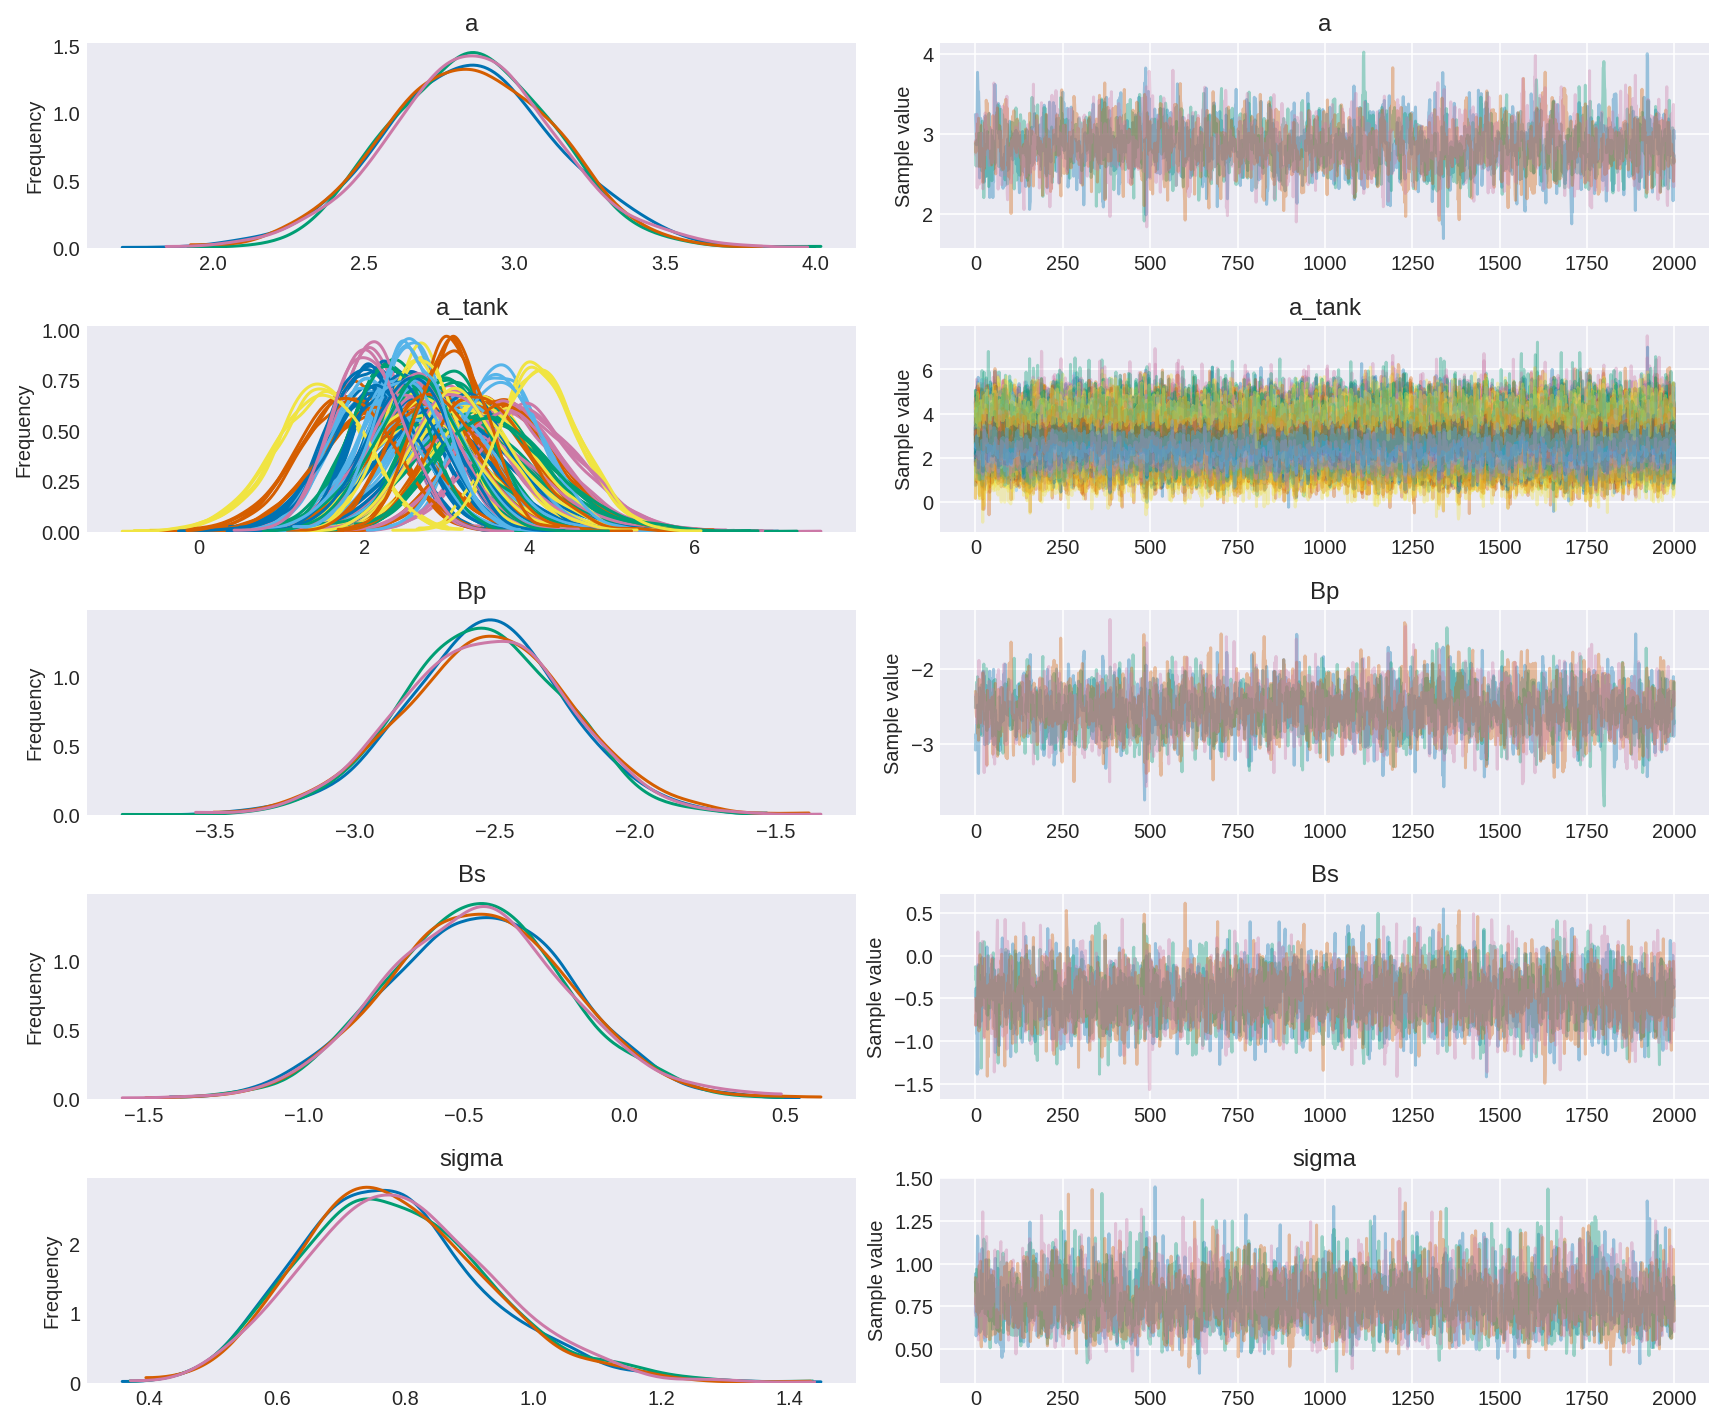

In [30]:
######################################
####     SIZE  &   PREDATION   ######
# as predicators of survival prob ##
####################################


with pm.Model() as m_12_4:
    
    a = pm.Normal('a', 0., 10.) # hyper prior
    sigma = pm.HalfCauchy('sigma', 1.) # hyper prior
    
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0]) # prior
    Bp = pm.Normal('Bp', -1, 1) # expect predation to decrease probability of survival
    Bs = pm.Normal('Bs', 0,1) # no strong reason to think size will influence prob... right?
    
    
    p = pm.math.invlogit(a_tank[tank] + Bs * d['size'] + Bp * d.pred) 
    # modeling each bucket of tadpoles individuallly
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_12_4 = pm.sample(2000, tune=2000, njobs=4)
    
pm.traceplot(trace_12_4);

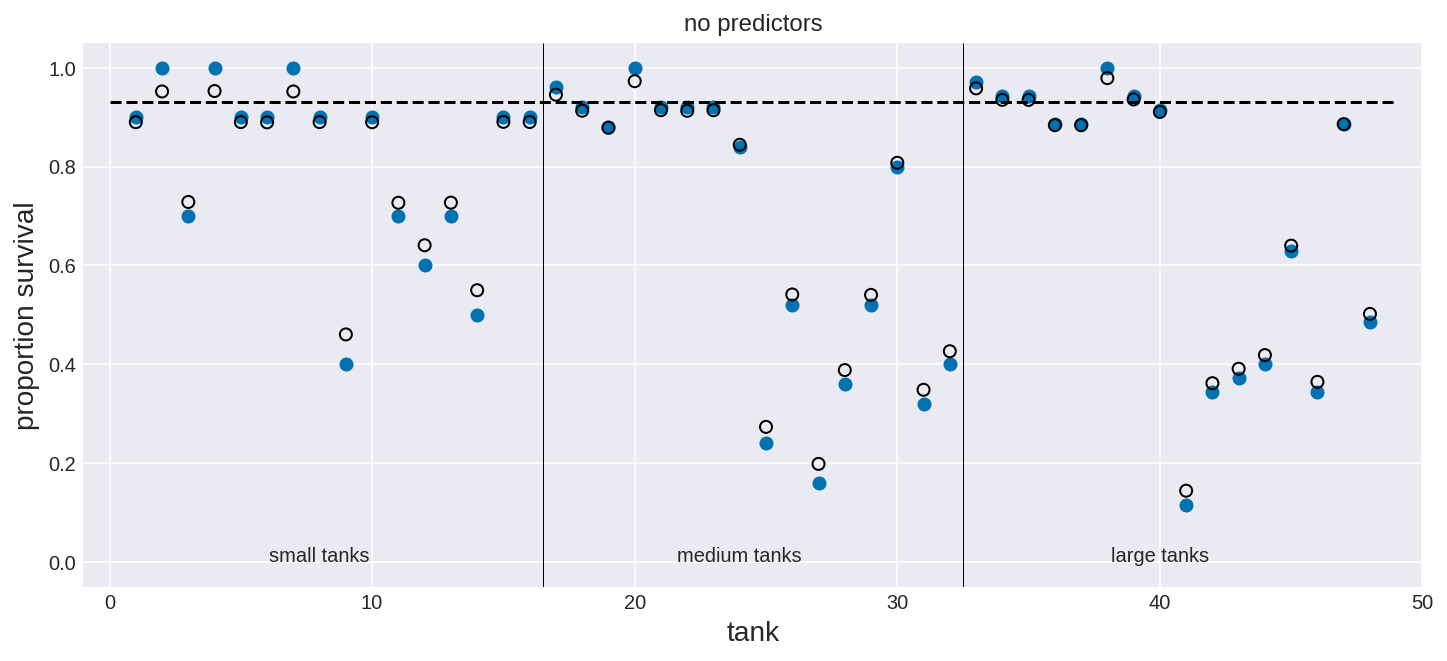

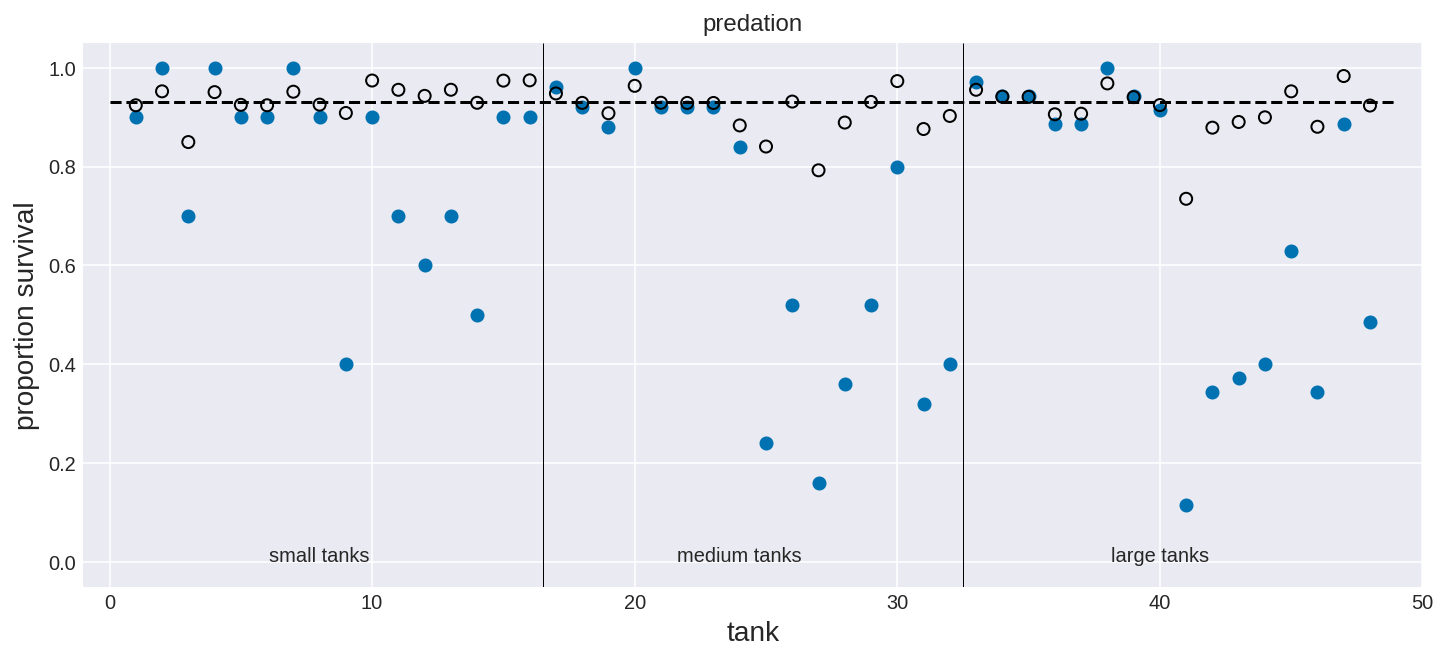

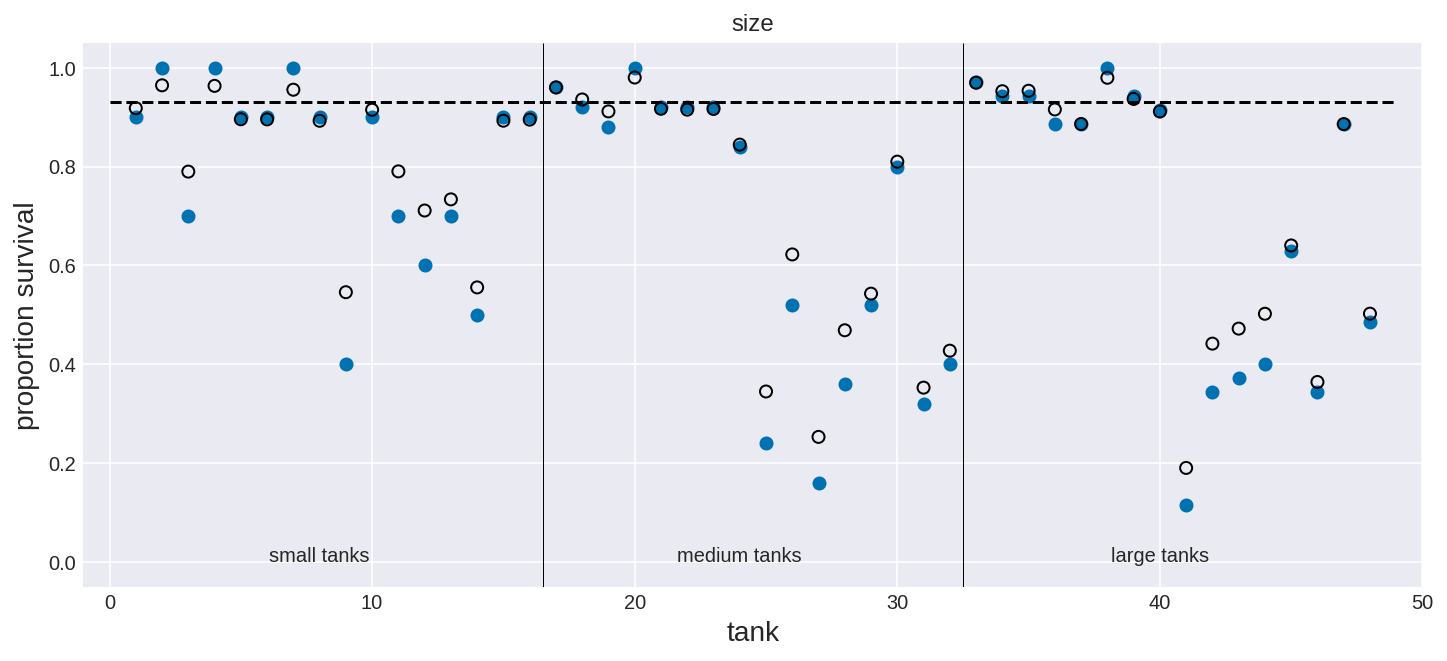

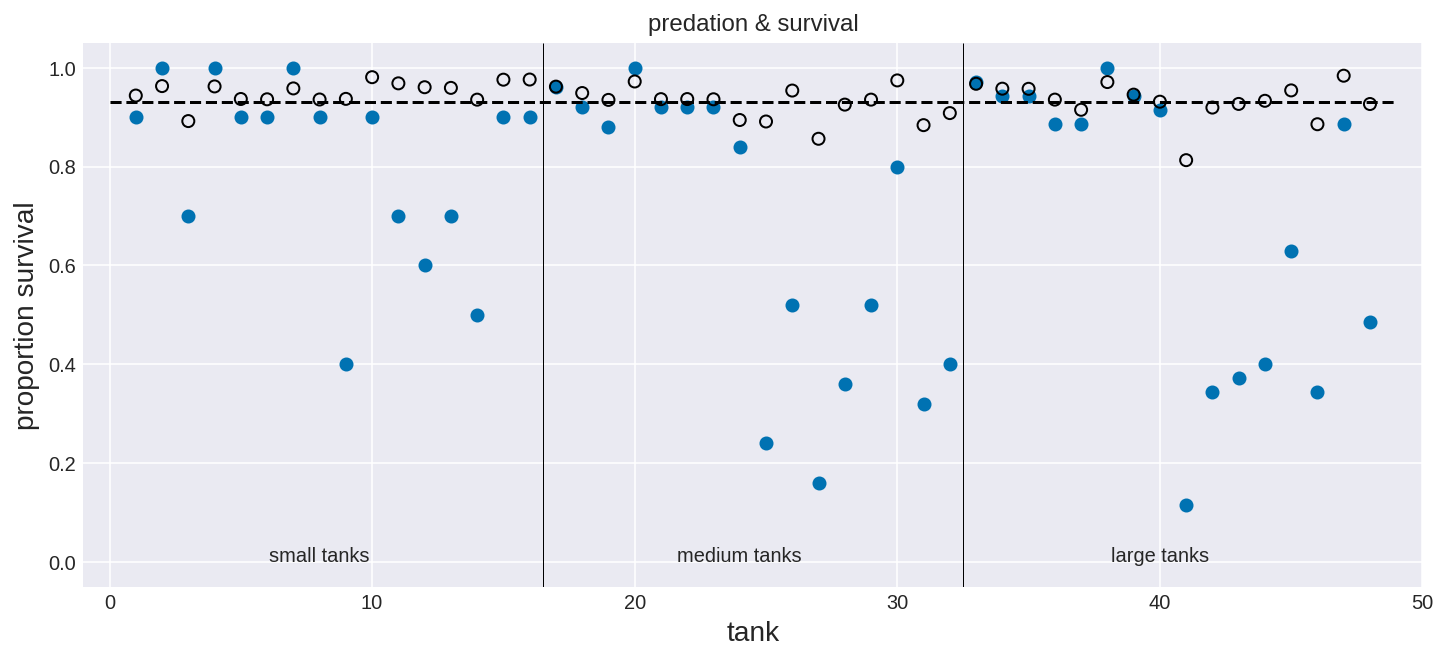

In [48]:

for i,trace in enumerate([trace_12_1, trace_12_2, trace_12_3, trace_12_4]):

    # extract PyMC3 samples
    post = pm.trace_to_dataframe(trace, varnames=['a_tank'])

    # compute median intercept for each tank
    # also transform to probability with logistic
    d.loc[:, 'propsurv_est'] = pd.Series(logistic(post.median(axis=0).values), index=d.index)
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    # display raw proportions surviving in each tank
    ax.scatter(np.arange(1, 49), d.propsurv)
    ax.scatter(np.arange(1, 49), d.propsurv_est,
                 facecolors='none', edgecolors='k', lw=1)
    ax.hlines(logistic(np.median(trace_12_2['a'], axis=0)), 0, 49, linestyles='--')
    ax.vlines([16.5, 32.5], -.05, 1.05, lw=.5)
    ax.text(8, 0, "small tanks", horizontalalignment='center')
    ax.text(16+8, 0, "medium tanks", horizontalalignment='center')
    ax.text(32+8, 0, "large tanks", horizontalalignment='center')
    ax.set_xlabel('tank', fontsize=14)
    ax.set_ylabel('proportion survival', fontsize=14)
    ax.set_xlim(-1, 50)
    ax.set_ylim(-.05, 1.05)
    titles = ['no predictors','predation','size','predation & survival']
    ax.set_title(titles[i]);

Wow! 

We see a huge increase in shrinkage once we put predation into the model. Instead of their being a lot of variability based on the individual tanks, maybe alot of this variability is due to there being predation or not. And once we account for this by adding it to the model, We become more skeptical of inter tank variability. Thus, the model shrinks the estimates very strongly across tanks, because predation seems to be acounting for this. 

In [32]:
########
# 12M2 #
########

comp_df = pm.compare({m_12_2 : trace_12_2, 
                      m_12_3 : trace_12_3,
                      m_12_4 : trace_12_4},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['predation_only','size_only', 'size_&_predation'])
comp_df = comp_df.set_index('model')
comp_df

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
predation_only,199.22,19.28,0,0.49,9.22,0,1
size_&_predation,200.01,19.26,0.8,0.33,8.76,1.9,1
size_only,201.19,21.42,1.97,0.18,7.29,5.85,1


Oh man! It sure is great that the lowest WAIC model is the one intuition would pick. Predation only has the lowest out of sample predicted deviance (~error). We actually achieve a bit more shrinkage in the size plus predation model, indicated by the smaller number of effective parameters. Although, based only on the WAIC size and predation plus size do fairly well, and depsite the overall trend making sense, this reinforces McElreath's point, "to compare models not select."   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [01:03<00:00, 251.41draws/s]
The acceptance probability does not match the target. It is 0.9520538986797751, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9546161971393253, but should be close to 0.8. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.24396792749877558, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


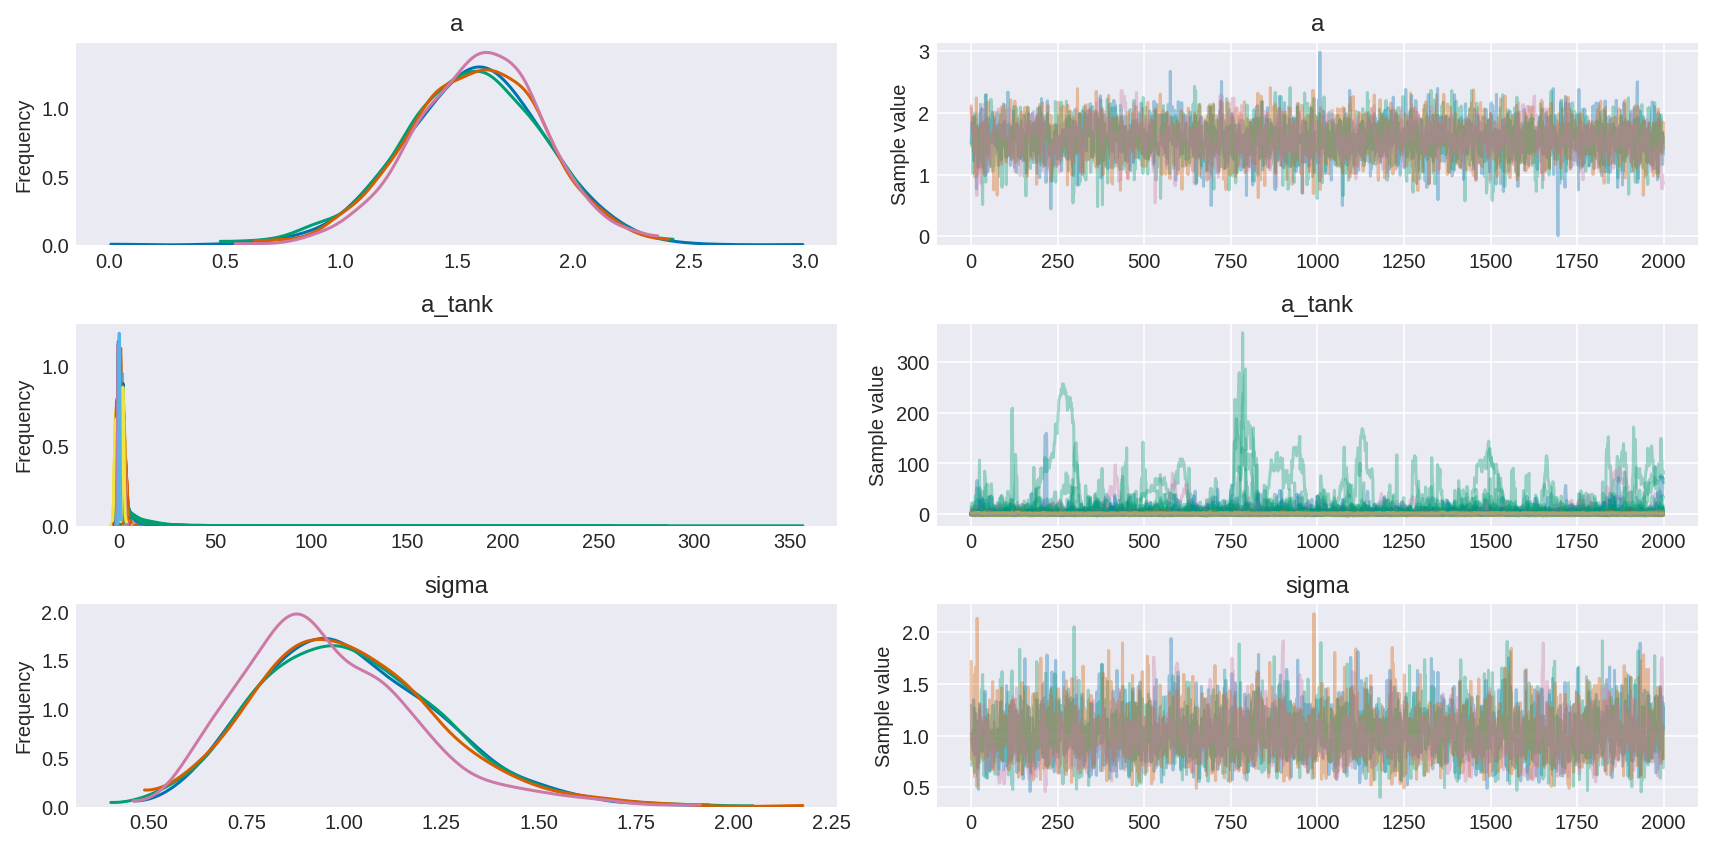

In [53]:
# 12M3  Re-estimate the basic Reed frog varying intercept model, but now using a Cauchy distribution
#    in place of the Gaussian distribution for the varying intercepts.

######## HIERARCHICAL ########
####### TADPOL SURVIVAL ######
# ========================== #

with pm.Model() as m_12_5:
    
    a = pm.Normal('a', 5., 3.) # hyper prior
    sigma = pm.HalfCauchy('sigma', 1.) # hyper prior
    
    a_tank = pm.Cauchy('a_tank', a, sigma, shape=d.shape[0]) # prior
    
    p = pm.math.invlogit(a_tank[tank]) # modeling each bucket of tadpoles individuallly
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_12_5 = pm.sample(2000, tune=2000, njobs=4)
    
pm.traceplot(trace_12_5);


In [52]:
pm.summary(trace_12_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.406451,0.299014,0.011078,0.830311,1.971407,524.017148,1.015488
a_tank__0,1.996482,0.837138,0.029696,0.517811,3.689385,733.961833,1.000496
a_tank__1,5.610816,7.750420,0.395079,0.502741,17.690237,346.514223,1.011531
a_tank__2,1.086169,0.609518,0.020425,-0.184184,2.230571,1019.999332,0.999895
a_tank__3,19.685828,71.611430,6.675808,-0.019936,78.885016,24.821789,1.085606
a_tank__4,1.998826,0.849111,0.026047,0.511678,3.783852,893.764567,1.002738
a_tank__5,2.040746,0.876609,0.029757,0.438401,3.810796,811.281996,1.000419
a_tank__6,79.974035,148.988050,14.877581,0.354417,453.757281,2.852320,2.323378
a_tank__7,2.070797,0.917512,0.035359,0.477973,4.061535,521.237408,1.002848
a_tank__8,-0.094170,0.667698,0.021008,-1.400161,1.170259,835.463819,1.001178
